In [3]:
import random_walk as rw
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid

In [5]:
dataset = Planetoid(root='data/Cora', name='Cora')
node2vec = rw.Node2Vec(dataset[0], p=0.5, q=0.5) # balance
node2vec.preprocess_transition_probs()
walks = node2vec.simulate_walks(num_walks=50, walk_length=80)
model = Word2Vec(walks, 
                 vector_size=128, 
                 window=10, 
                 min_count=0,
                 sg=1, 
                 workers=16, 
                 epochs=20)

Preprocessing transition probabilities...
Preprocessing done.
Simulating walks...
Walks simulation done.


In [6]:
import numpy as np
ordered_embeddings = []
# data.num_nodes 是 PyG 图的节点总数
for i in range(dataset[0].num_nodes):
    # 我们训练时把节点转成了 string，所以这里用 str(i) 取回
    # 加上 try-except 是防止有些孤立点没被游走到（虽然 min_count=0 应该都有）
    if str(i) in model.wv:
        ordered_embeddings.append(model.wv[str(i)])
    else:
        # 如果万一有节点没被训练到，给个零向量占位
        ordered_embeddings.append(np.zeros(128))

embeddings = np.array(ordered_embeddings)

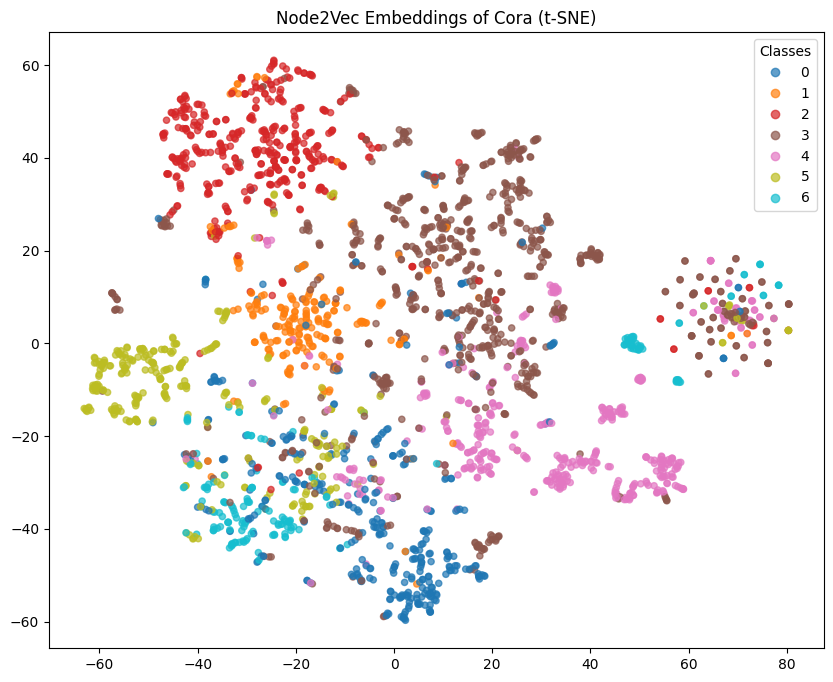

In [7]:
from sklearn.manifold import TSNE

# 使用 t-SNE 替代 PCA
# perplexity 通常在 30-50 之间，n_iter 建议 1000 以上
tsne = TSNE(n_components=2, perplexity=30,  random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dataset[0].y, cmap='tab10', alpha=0.7, s=20)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Node2Vec Embeddings of Cora (t-SNE)')
plt.show()

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, dataset[0].y.numpy(), test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f'SVM Classification Accuracy on Node2Vec Embeddings: {accuracy:.4f}')

SVM Classification Accuracy on Node2Vec Embeddings: 0.8469


# Bonus: Tune the hyperparameters to achieve better performance.

In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

param_grid = [
    {'p': 1.0, 'q': 1.0, 'name': 'DeepWalk (Baseline)'},
    {'p': 0.5, 'q': 0.5, 'name': 'Balanced'},
    {'p': 4.0, 'q': 0.25, 'name': 'Structural (DFS-like)'},
    {'p': 0.25, 'q': 4.0, 'name': 'Community (BFS-like)'},
]

results = []

print("Start Grid Search for Hyperparameters...")
print("-" * 60)

for params in param_grid:
    p, q = params['p'], params['q']
    print(f"Testing: p={p}, q={q} ({params['name']})...")
    
    dataset = Planetoid(root='data/Cora', name='Cora')
    node2vec = rw.Node2Vec(dataset[0], p=p, q=q)
    node2vec.preprocess_transition_probs()
    walks = node2vec.simulate_walks(num_walks=50, walk_length=80)

    model = Word2Vec(walks, vector_size=128, window=10, min_count=0, 
                     sg=1, workers=18, epochs=20)
    
    embeddings = []
    nodes_list = list(range(dataset[0].num_nodes))
    for node_id in nodes_list:
        if str(node_id) in model.wv:
            embeddings.append(model.wv[str(node_id)])
        else:
            embeddings.append(np.zeros(128))
    X = np.array(embeddings)
    y_true = dataset[0].y.numpy()
    # 5. 评估分类准确率
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    
    print(f"--> Accuracy: {acc:.4f}")
    
    results.append({
        'p': p, 'q': q, 
        'Mode': params['name'],
        'Accuracy': acc
    })

print("-" * 60)
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
display(df_results)

Start Grid Search for Hyperparameters...
------------------------------------------------------------
Testing: p=1.0, q=1.0 (DeepWalk (Baseline))...
Preprocessing transition probabilities...
Preprocessing done.
Simulating walks...
Walks simulation done.
--> Accuracy: 0.8266
Testing: p=0.5, q=0.5 (Balanced)...
Preprocessing transition probabilities...
Preprocessing done.
Simulating walks...
Walks simulation done.
--> Accuracy: 0.8413
Testing: p=4.0, q=0.25 (Structural (DFS-like))...
Preprocessing transition probabilities...
Preprocessing done.
Simulating walks...
Walks simulation done.
--> Accuracy: 0.8376
Testing: p=0.25, q=4.0 (Community (BFS-like))...
Preprocessing transition probabilities...
Preprocessing done.
Simulating walks...
Walks simulation done.
--> Accuracy: 0.7601
------------------------------------------------------------


,p,q,Mode,Accuracy
1,0.50,0.50,Balanced,0.841328
2,4.00,0.25,Structural (DFS-like),0.837638
0,1.00,1.00,DeepWalk (Baseline),0.826568
3,0.25,4.00,Community (BFS-like),0.760148


最终我们还是选取balance的参数，即p=q=0.5

# bonus2: 分析  
对于Cora的数据，似乎从感性上感觉应该是在局部探索性能会更好一些。然而很令人惊讶的是，实际上我们发现高度保守的BFS倾向参数选择(0.25,4)反而展现出了不良的表现。这是一个很令人困惑的事情。我对这个现象的理解是，由于我们word2vec的限制，我们的window的长度只有10.对于BFS的设置，实际上生成的序列会出现高度同质化的现象。大量的冗余信息导致模型过拟合了局部结构，而没学到这篇论文所属的“大类（Cluster）”特征。  
对于balance方案，我们可以来计算一下其各种方案的概率。其向外探索的权重为2,回到原始点的权重为2，到一阶邻居的权重为1.这样的设置可以使得模型倾向于相对激进的主动探索状态，从而获得丰富的上下文信息，提升模型embedding的质量。